# SE and STE

In [6]:
import numpy as np
import rasterio
from rasterio.plot import show
import os

# Load image
def load_image(file_path):
    """
    Load an image file and return the image data and related information
    """
    with rasterio.open(file_path) as src:
        img = src.read(1)  # Read the first band
        transform = src.transform  # Get the transform information
        nodata = src.nodata  # Get the no data value

        # Get origin coordinates and pixel size
        img_origin_x = transform[2]  # Top-left X coordinate
        img_origin_y = transform[5]  # Top-left Y coordinate
        pixel_size = transform[0]  # Pixel size (usually positive)

    return img, transform, img_origin_x, img_origin_y, pixel_size, nodata


def to_one_hot(image, num_classes):
    """
    Convert a classified image to one-hot encoding format
    """
    one_hot_image = np.zeros((image.shape[0], image.shape[1], num_classes), dtype=int)
    for i in range(num_classes):
        one_hot_image[:, :, i] = (image == i).astype(int)
    return one_hot_image


def calculate_SE(one_hot_image):
    """
    Calculate the spatial entropy of an image (SE)
    """
    rows, cols, num_classes = one_hot_image.shape
    padded_image = np.pad(one_hot_image, ((1, 1), (1, 1), (0, 0)), mode='edge')
    entropy_image = np.zeros((rows, cols), dtype=float)

    for i in range(rows):
        for j in range(cols):
            neighborhood = padded_image[i:i+3, j:j+3, :]
            counts = neighborhood.sum(axis=(0, 1))  # Count occurrences of each class
            total_count = counts.sum()
            
            if total_count > 0:
                probabilities = counts / total_count  # Calculate class probabilities
                entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))  # Compute entropy with small constant to avoid log(0)
                entropy_image[i, j] = entropy
            else:
                entropy_image[i, j] = 0  # If no valid classification in the neighborhood, set entropy to 0

    return entropy_image


def calculate_STE(one_hot_images, neighborhood_size):
    """
    Calculate the spatiotemporal entropy of a set of images(STE)
    """
    rows, cols, num_classes = one_hot_images[0].shape
    pad_width = neighborhood_size // 2  # Calculate padding width
    padded_images = [np.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='edge') for image in one_hot_images]
    entropy_image = np.zeros((rows, cols), dtype=float)

    for i in range(rows):
        for j in range(cols):
            counts = np.zeros(num_classes)
            for k in range(len(one_hot_images)):
                neighborhood = padded_images[k][i:i+neighborhood_size, j:j+neighborhood_size, :]
                counts += neighborhood.sum(axis=(0, 1))  # Count occurrences of each class

            total_count = counts.sum()
            
            if total_count > 0:
                probabilities = counts / total_count  # Calculate class probabilities
                entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))  # Compute entropy
                entropy_image[i, j] = entropy
            else:
                entropy_image[i, j] = -1  # If no valid classification in the neighborhood, set entropy to -1

    return entropy_image


def save_entropy_to_raster(entropy_image, output_path, transform, crs='EPSG:4326'):
    """
    Save entropy image to a GeoTIFF file
    """
    with rasterio.open(output_path, 'w', driver='GTiff', height=entropy_image.shape[0], width=entropy_image.shape[1],
                       count=1, dtype='float32', transform=transform, crs=crs) as dst:
        dst.write(entropy_image, 1)
    # Output file path
    print(f"Entropy image saved to: {output_path}")


def process_images_and_save_entropy(images_paths, output_paths, neighborhood_size=3):
    """
    Process three images, compute spatial and spatiotemporal entropy, and save the results as GeoTIFF files
    """
    # Load images
    images = [load_image(path) for path in images_paths]
    
    # Extract image data and metadata
    imgs = [img[0] for img in images]
    transforms = [img[1] for img in images]
    
    # One-hot encoding
    one_hot_images = [to_one_hot(img, num_classes=7) for img in imgs]
    
    # Calculate entropy values
    entropy_images = [calculate_SE(one_hot_img) for one_hot_img in one_hot_images]
    entropy_3d_image = calculate_STE(one_hot_images, neighborhood_size)

    # Save spatial entropy images
    for entropy_image, output_path in zip(entropy_images, output_paths[:3]):
        save_entropy_to_raster(entropy_image, output_path, transforms[0])

    # Save spatiotemporal entropy image
    save_entropy_to_raster(entropy_3d_image, output_paths[3], transforms[0])

# Get the current script directory
base_path = os.path.abspath('')  # Get the absolute path of the current working directory

# Define image paths and output paths
images_paths = [
    os.path.join(base_path, 'data', 'PITSCM', 'TS_2019_RF.tif'),
    os.path.join(base_path, 'data', 'PITSCM', 'TS_2020_RF.tif'),
    os.path.join(base_path, 'data', 'PITSCM', 'TS_2021_RF.tif')
]

output_paths = [
    os.path.join(base_path, 'data', 'SE_STE', 'TS_2019_RF_SE.tif'),
    os.path.join(base_path, 'data', 'SE_STE', 'TS_2020_RF_SE.tif'),
    os.path.join(base_path, 'data', 'SE_STE', 'TS_2021_RF_SE.tif'),
    os.path.join(base_path, 'data', 'SE_STE', 'TS_RF_StE.tif')
]

# Call the function to process and save entropy
process_images_and_save_entropy(images_paths, output_paths, neighborhood_size=3)


Entropy image saved to: g:\1009\JAG\返修_20250124前交\代码上传\data\SE_STE\TS_2019_RF_SE.tif
Entropy image saved to: g:\1009\JAG\返修_20250124前交\代码上传\data\SE_STE\TS_2020_RF_SE.tif
Entropy image saved to: g:\1009\JAG\返修_20250124前交\代码上传\data\SE_STE\TS_2021_RF_SE.tif
Entropy image saved to: g:\1009\JAG\返修_20250124前交\代码上传\data\SE_STE\TS_RF_StE.tif


C:\Users\admin 1\AppData\Local\Temp\ipykernel_44460\1982955092.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])  # Ensure the overall layout does not overlap


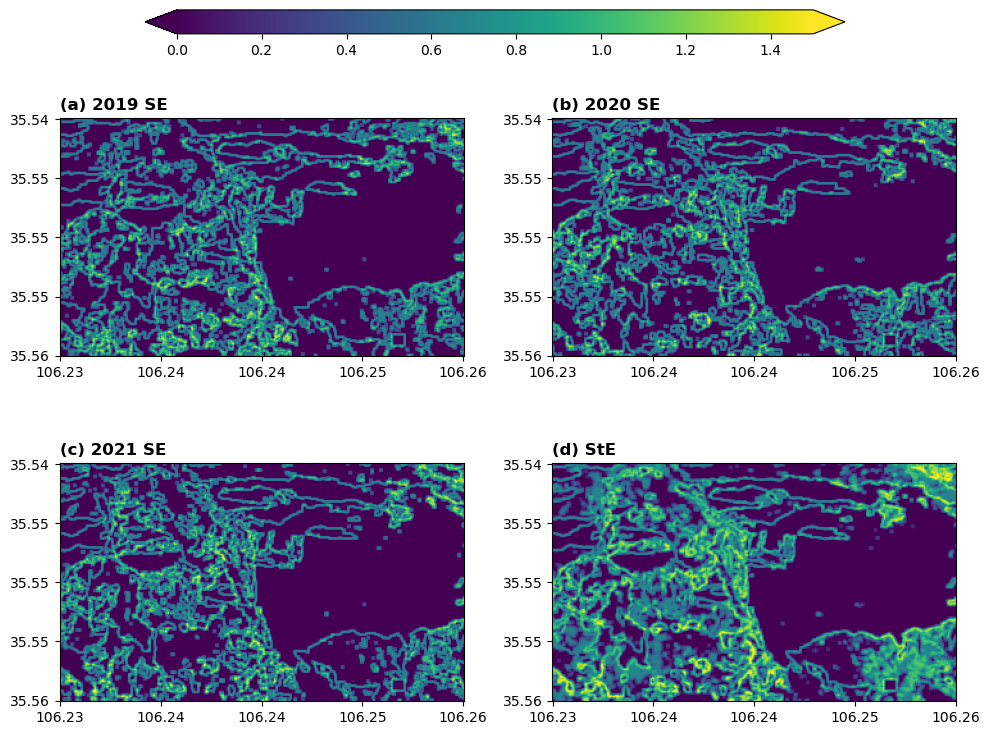

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_images(data_paths, titles, meters_per_pixel=10, output_fig_size=(10, 8)):
    """
    Plot multiple images, each displayed in its own subplot.
    
    Parameters:
    data_paths (list): List of image file paths.
    titles (list): List of titles corresponding to each image.
    meters_per_pixel (float): Actual distance represented by each pixel, default is 10 meters/pixel.
    output_fig_size (tuple): Size of the output figure, default is (10, 8).
    """
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=output_fig_size)
    axs = axs.flatten()  # Flatten the 2D array into a 1D array for easy indexing

    # Initialize min and max values
    min_value = 0
    max_value = 1.5

    # Display each image
    for i, (data_path, title) in enumerate(zip(data_paths, titles)):
        # Read the data
        data = rasterio.open(data_path)
        img_data = data.read(1)

        # Display the image
        im = axs[i].imshow(img_data, cmap='viridis', vmin=min_value, vmax=max_value)  # Use a range from 0 to 1.5
        axs[i].set_title(f'{title}', loc='left', weight='bold')
        axs[i].axis('on')  # Enable axis

        # Add latitude and longitude ticks
        axs[i].set_xticks(np.linspace(0, img_data.shape[1]-1, num=5))
        axs[i].set_yticks(np.linspace(0, img_data.shape[0]-1, num=5))

        # Set x and y labels
        x_labels = np.round(np.linspace(data.bounds.left, data.bounds.right, num=5), 2)
        y_labels = np.round(np.linspace(data.bounds.bottom, data.bounds.top, num=5), 2)
        axs[i].set_xticklabels(x_labels)  # , rotation=45
        axs[i].set_yticklabels(y_labels)

    # Add a unified color bar at the top of the entire figure
    cbar_ax = fig.add_axes([0.15, 0.92, 0.7, 0.03])  # Set the position and size of the color bar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')  # Use the last image's im
    # cbar.set_label('Entropy Value')  # Modify the color bar label as needed

    # Adjust layout to reduce spacing between columns
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.85)  # Control column and row spacing

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Ensure the overall layout does not overlap

    plt.show()

# Get the absolute path of the current script's directory
base_path = os.path.abspath('')  # Get the absolute path of the current working directory

# Define the image paths to be displayed and their corresponding titles
data_paths = [
    os.path.join(base_path, 'data', 'SE_STE', 'TS_2019_RF_SE.tif'),
    os.path.join(base_path, 'data', 'SE_STE', 'TS_2020_RF_SE.tif'),
    os.path.join(base_path, 'data', 'SE_STE', 'TS_2021_RF_SE.tif'),
    os.path.join(base_path, 'data', 'SE_STE', 'TS_RF_StE.tif')
]
titles = ['(a) 2019 SE', '(b) 2020 SE', '(c) 2021 SE', '(d) StE']

# Call the function to plot the images
plot_images(data_paths, titles)
